<a href="https://colab.research.google.com/github/ak7991/NLP_classifier_RNN_LSTM/blob/main/text_classification_lstm_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of charactors or a sequence of words, but it's most common to work at level of words. Text-sequence processing includes following applications:

**Applications of deep learning for text data:**
1. Document classification
2. Articles lebelling
3. Sentiment analysis
4. Author identification
5. Question-answering
6. Language detection
7. Translation Tasks

- In true sense `deep learning models map the statistical structure of written language,` which is sufficient to solve many simple textual tasks and problems.
- Deep learning for natural-language processing is `pattern recognition applied to words, sequence, and paragraphs,` in much similar way that computer vision is pattern recognition applied to pixels.
- Deep-learning models don't take input as text like other models they only work with numeric tensors

**Three techniques to vectorize the text data:**
1. Segment text into words, and convert word into a vector
2. Segment text into charactors, and transform each chractors into a vector.
3. Extract n-grams of words, and transform each n-grams into a vector.

- There are many ways one can convert text to vector and it depends on what models one is using along with time or resources utilization.

**Typical workflow to prepare text data for machine learning models:**
1. Tokenization
2. One-Hot encoding or word indexing
3. Pad sequencing 
4. Embedding layer (Word2Vec)
5. Corresponding word vector

- In this notebook, we are going to explore and solve news classification problem to classify 41 types of news headlines and news descriptions.

**Use-case:** Such text classification models are used in `News Apps` or by reporter to classify news topics for better reach to right audience.

**Problem-statement:** Build `news classification model` using deep learning teechniques and deploy model for reporters to classify and label news articles.

*Reference: Deep learning with python by Francois Chollet*

# Table of contents:

0. [Importing libraries](#lib)
1. [Data exploration and pre-processing](#eda)

  - [Profiling report of dataset](#pp)
  - [Text data visualization](#td)
  - [Text data pre-processing](#tdp)
  
  
2. [Tokenization and vectorization](#tv)
3. [What are the word embeddings?](#we)
4. [Model training using EmbeddingLayer,RNNs and LSTMs](#rnn) 

  - [Baseline model 1](#base)
  - [What are the RNNs?](#rnets)
  - [Model training using LSTM](#model2)
  - [Loss and accuracy curve](#loss)
  
  
5. [Conclusion](#conclude)

# 0. Importing libraries

<a id="lib"></a>


In [106]:
from nltk.stem.wordnet import WordNetLemmatizer

In [107]:
import os
import re

import numpy as np
import pandas as pd 
import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2


In [108]:
# Configs
%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
nltk.download('wordnet')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data exploration and pre-processing

<a id="eda"></a>


In [109]:
filename = "news_category.csv"
df = pd.read_csv(filename)
df.head()

,Unnamed: 0,link,headline,category,short_description,authors,date
0,0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [110]:
# Define columns
# Irrelavant columns
UNWANTED_COLUMNS = ['authors','link','date']

# Relavant columns
FEATURE_COLUMNS = ['headline', 'short_description']

# concat if multiple targets
TARGET_COLUMN = 'category'

In [111]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print(f"Unique {TARGET_COLUMN}:", df['category'].nunique())
print(f"Distinct {TARGET_COLUMN}:", df['category'].unique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 7)
Unique category: 42
Distinct category: ['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         209527 non-null  int64 
 1   link               209527 non-null  object
 2   headline           209521 non-null  object
 3   category           209527 non-null  object
 4   s

In [112]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,Unnamed: 0
count,209527.000000
mean,104763.000000
std,60485.379264
min,0.000000
25%,52381.500000
50%,104763.000000
75%,157144.500000
max,209526.000000


## 1.1 Profiling report of dataset

<a id="pp"></a>


In [113]:
# produce pandas profiling report

# Takes alot of time

# df.profile_report()

**Key findings:**

1. Dataset has total **41** distinct categories of news articles
2. **'Politics'** is the most common category of news in our dataset.
3. We have total of **27993** unique authors who have written various news articles
4. Maximum length of headline is **320** while median length is around **59.**
5. Maximum length of description is **1472** while median length is around **120.**

## 1.2 Text data visualization

<a id="td"></a>


In [114]:
# drop columns like which don't have effect on TARGET_COLUMNN
cropped_df = df.drop(columns=UNWANTED_COLUMNS)
cropped_df.head()

,Unnamed: 0,headline,category,short_description
0,0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


### 1.2.1 TOP 10 Categories of News Articles

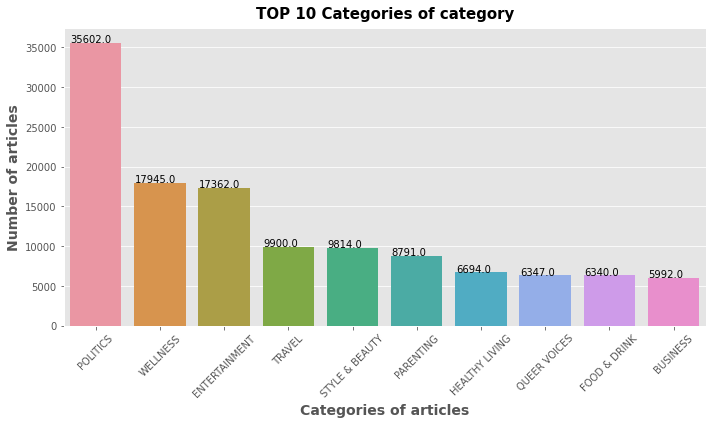

In [115]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(cropped_df[TARGET_COLUMN].value_counts()).reset_index()
cat_df.rename(columns={'index': f'{TARGET_COLUMN}_classes', TARGET_COLUMN:'numcat'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df[f'{TARGET_COLUMN}_classes'])[:10], np.array(cat_df['numcat'])[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title(f"TOP 10 Categories of {TARGET_COLUMN}", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

In [116]:
# No need for pie charts; pie charts are dead

# plot the pie chart of top 20 categories of news articles
# fig = plt.figure(figsize=(12,12))
# A = plt.pie(cat_df['numcat'][:20],
#             labels=cat_df[f'{TARGET_COLUMN}_classes'][:20],
#             autopct='%1.1f%%',
#             startangle=90,
#             labeldistance=1.08,
#             pctdistance=1.03,
#             rotatelabels=45
#             )

# plt.title(f"Pie Chart of TOP 20 {TARGET_COLUMN} of news articles", size=20, weight='bold')
# plt.show()

### 1.2.2 Lengths of 'headline' and 'short_description' of each category

In [117]:
cropped_df.head()

,Unnamed: 0,headline,category,short_description
0,0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [118]:
# # create final dataframe of combined headline and short_description
filtered_df = cropped_df.dropna(axis=0)
filtered_df['concat_feature'] = filtered_df[FEATURE_COLUMNS].apply(lambda x: ' '.join(x), axis=1)
filtered_df.drop(FEATURE_COLUMNS, inplace=True, axis=1)
filtered_df['len_feature'] = filtered_df['concat_feature'].str.len()
filtered_df.head()

,Unnamed: 0,category,concat_feature,len_feature
0,0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,231
1,1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",249
2,2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,134
3,3,PARENTING,The Funniest Tweets From Parents This Week (Se...,216
4,4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,234


In [119]:
# maximum length of news in each category
lenmax_df = filtered_df.groupby(TARGET_COLUMN)['len_feature'].max().reset_index().sort_values(by='len_feature',ascending=False)
lenmax_df.head()

,category,len_feature
24,POLITICS,1487
41,WORLDPOST,1425
4,COLLEGE,1226
16,HEALTHY LIVING,1074
38,WELLNESS,1037


In [120]:
# minimum lenght of news in each category
lenmin_df = filtered_df.groupby(TARGET_COLUMN)['len_feature'].min().reset_index().sort_values(by='len_feature',ascending=False)
lenmin_df.head()

,category,len_feature
0,ARTS,90
35,U.S. NEWS,74
8,DIVORCE,67
12,FIFTY,63
6,CRIME,61


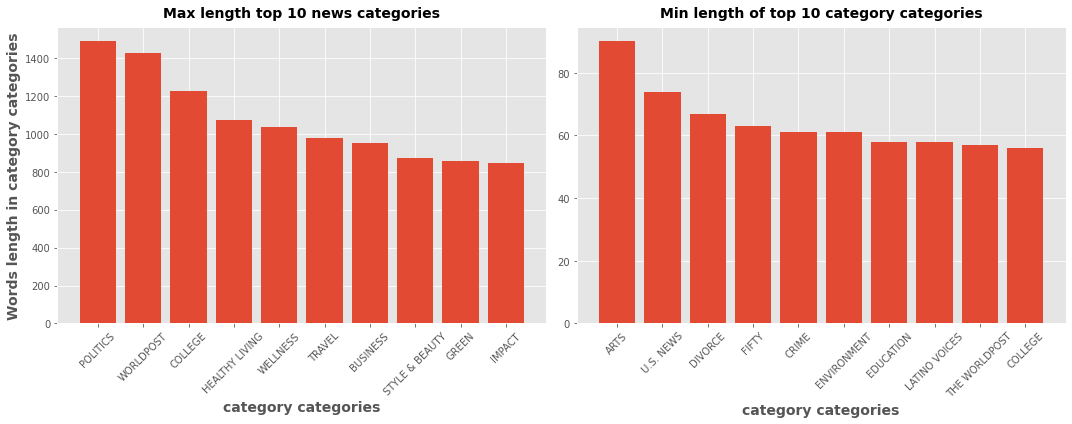

In [121]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_feature'][:10])
plt.xticks(rotation=45)
plt.ylabel(f"Words length in {TARGET_COLUMN} categories", size=14)
plt.xlabel(f"{TARGET_COLUMN} categories",  size=14)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df[TARGET_COLUMN][:10], lenmin_df['len_feature'][:10])
plt.xticks(rotation=45)
plt.xlabel(f"{TARGET_COLUMN} categories", size=14)
plt.title(f"Min length of top 10 {TARGET_COLUMN} categories", size=14)

plt.show()

### 1.2.3 Wordclouds of categories and news articles

- Wordcloud of categories in out dataframe
- Wordcloud of new articles in each of the categories

In [122]:
combined_target_corpus = ' '.join(filtered_df.dropna()[TARGET_COLUMN])
combined_target_corpus[:100]

'U.S. NEWS U.S. NEWS COMEDY PARENTING U.S. NEWS U.S. NEWS U.S. NEWS WORLD NEWS CULTURE & ARTS WORLD N'

In [123]:
len(filtered_df[TARGET_COLUMN].drop_duplicates())

42

(-0.5, 1599.5, 599.5, -0.5)

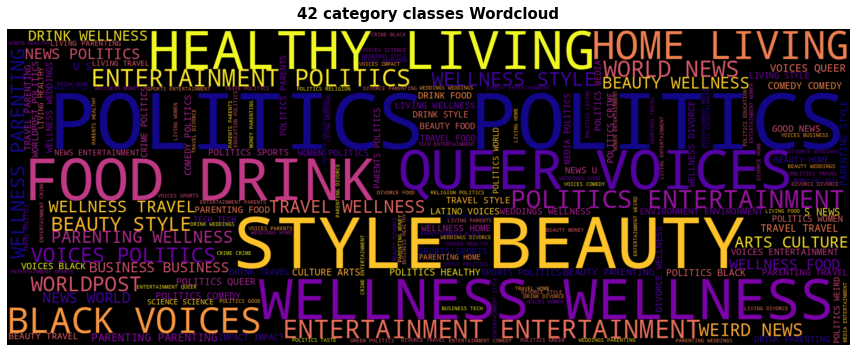

In [124]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(combined_target_corpus)

plt.title(f"{filtered_df[TARGET_COLUMN].nunique()} {TARGET_COLUMN} classes Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

In [125]:
filtered_df

,Unnamed: 0,category,concat_feature,len_feature
0,0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,231
1,1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",249
2,2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,134
3,3,PARENTING,The Funniest Tweets From Parents This Week (Se...,216
4,4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,234
...,...,...,...,...
209522,209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,183
209523,209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,192
209524,209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",221
209525,209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,174


In [126]:
# create new dataframe of category and length of each news articles in that categories
training_df = filtered_df.drop(['len_feature'], axis=1)
target_freq_df = training_df.groupby(TARGET_COLUMN).agg(occurences=('concat_feature', 'count'))

In [127]:
training_df

,Unnamed: 0,category,concat_feature
0,0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...
...,...,...,...
209522,209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
209523,209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
209524,209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
209525,209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [128]:
top_ten_classes = target_freq_df.sort_values(['occurences'], ascending=[False]).reset_index()[:10]
top_ten_classes

,category,occurences
0,POLITICS,32441
1,WELLNESS,17943
2,ENTERTAINMENT,14774
3,STYLE & BEAUTY,9802
4,TRAVEL,9421
5,PARENTING,8790
6,FOOD & DRINK,6331
7,QUEER VOICES,5603
8,HEALTHY LIVING,5265
9,BUSINESS,5132


In [129]:
# Uncomment everything below to generate wordclouds for text corpus of each
# class invidually

# Warning: takes a lot of time






# # list of top 10  categories in the dataset
# # top_ten_classes = target_freq_df.sort_values(['occurences'], ascending=[False])[TARGET_COLUMN].to_list()
# print("Top 10 categories: \n", top_ten_classes[TARGET_COLUMN])

# # list of news articles of each top 10 categories list
# articles_list = []

# for i in top_ten_classes[TARGET_COLUMN]:
#     cat_ndf = training_df[training_df[TARGET_COLUMN] == i]
#     cat_array = cat_ndf['concat_feature'].values  # array of news articles text in each category
#     articles_list.append(cat_array)

# print("============", articles_list[0])
# # create a wordcloud instance
# wc1 = WordCloud(max_words=1000, 
#                min_font_size=10,
#                height=600,
#                width=1600,
#                background_color='black',
#                contour_color='black',
#                colormap='plasma',
#                repeat=True,
#                stopwords=STOPWORDS)

# # plot the figure of 10 wordcloud from out dataset
# plt.figure(figsize=(15,15))

# for idx, j in enumerate(top_ten_classes[TARGET_COLUMN]):
#     plt.subplot(5,2,idx+1)
#     cloud = wc1.generate(' '.join(articles_list[idx]))
#     plt.imshow(cloud, interpolation= "bilinear")
#     plt.title(f"Wordcloud for {TARGET_COLUMN} {j}")
#     plt.axis('off')

## 1.3 Text-data Preprocessing 

<a id="tdp"></a>


In [131]:
training_df

,Unnamed: 0,category,concat_feature
0,0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...
...,...,...,...
209522,209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
209523,209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
209524,209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
209525,209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [132]:
# Reduce imbalances if possible
# If a class has too many rows it might make sense to drop some observations

politics_list = list(training_df[training_df[TARGET_COLUMN] == 'POLITICS'].index) 
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
balanced_training_df = training_df.copy()
balanced_training_df.drop(list_16, axis=0, inplace=True)

In [133]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)        

In [134]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n", balanced_training_df['concat_feature'][0])
print("---"*35)
print("Text sentence after pre-processing:\n", datacleaning(balanced_training_df['concat_feature'][0]))

Text sentence before pre-processing:
 Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 million americans roll sleeves omicrontargeted covid boosters health experts say early predict whether demand match million dose new boosters us order fall


In [135]:
# apply datacleaning function to concatenated feature column 'concat_feature'
balanced_training_df['concat_feature'] = balanced_training_df['concat_feature'].apply(datacleaning)

In [136]:
# length of total characters before and after cleaning text data
old_length = training_df['concat_feature'].apply(len).sum()
new_length = balanced_training_df['concat_feature'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 35265657
New chracters length of text data: 21934319


In [137]:
# length of total words before and after cleaning text data
old_text = training_df['concat_feature'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = balanced_training_df['concat_feature'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5951893
New word length of text data: 3229604


In [138]:
balanced_training_df.nunique()

Unnamed: 0        173814
category              42
concat_feature    173180
dtype: int64

# 2. Tokenization and vectorization

<a id="tv"></a>


### Some of the most common NLP terminologies

**1. Document**
- Each and every training example used in text dataset known as a Document.

**2. Corpus**
- Collections of documents called as a corpus of text data

**3. Vocabulary(BoW)**
- Vocabulary or Bag-of-words is nothing but number of unique words are present in text corpus.

**4. Stop words**
- Stop words are those used most commonly in any language, e.g. 'the', 'a', etc. they do not form any meaning to the context of the text

**5. N-grams**
- N-grams is text representation in form of N words sequences to extract meaning and context out of each sentences or paragraphs.

**6. Tokenization**
- It's an early step in NLP process to split text sentences into smaller words or tokens.

**7. Vectorization**
- Machine do not understand text or words, so text data or tokens must be converted to corrospinding word index or word vectors in order process text and build models. process of converting tokenized words into numerical vectors called as a vectorization.

### One-hot encoding and word-indexing example on chunk of data

In [140]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(balanced_training_df['concat_feature'][:5].values)  # samples of first 5 documents of out dataset

sample_corpus = ' '.join(samples)
unique_words = set(sample_corpus.split())
token_index = {}
idx = 0
for element in unique_words:
  idx += 1
  token_index[element] = idx
            
max_length = 15

# one dimension for each sample
# one dimension for each word
# one dimension to one-hot encode word (tell which word)
results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1)) 

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split())):
        if j == max_length:
            break
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 91)
Token index of unique words: 
 {'passengers': 1, 'accidentally': 2, 'lose': 3, 'airlines': 4, 'subdue': 5, 'los': 6, 'million': 7, 'demand': 8, 'americans': 9, 'order': 10, 'life': 11, 'reaper': 12, 'accuse': 13, 'carolina': 14, 'scream': 15, 'sept': 16, 'racist': 17, 'fire': 18, 'us': 19, 'attendant': 20, 'dip': 21, 'cooper': 22, 'tabasco': 23, 'flight': 24, 'amy': 25, 'put': 26, 'dog': 27, 'video': 28, 'call': 29, 'exemployer': 30, 'black': 31, 'understand': 32, 'new': 33, 'aircraft': 34, 'attorneys': 35, 'encounter': 36, 'sleeves': 37, 'funniest': 38, 'covid': 39, 'toothbrush': 40, 'cop': 41, 'ban': 42, 'week': 43, 'teeth': 44, 'templeton': 45, 'accord': 46, 'experts': 47, 'tweet': 48, 'lawsuit': 49, 'firm': 50, 'health': 51, 'clean': 52, 'investment': 53, 'office': 54, 'say': 55, 'franklin': 56, 'cat': 57, 'brand': 58, 'match': 59, 'woman': 60, 'omicrontargeted': 61, 'whether': 62, 'eat': 63, 'angeles': 64, 'central': 65, 'parent': 66, 'cr

### One-hot encoding and indexing of train and test data

In [141]:
tokenizer.get_config().keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [142]:
# one hot encoding using keras tokenizer and pad sequencing
X = balanced_training_df['concat_feature']
encoder = LabelEncoder()
y = encoder.fit_transform(balanced_training_df[TARGET_COLUMN])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

# each sample must of this length
# samples longer will be truncated;
# samples shorted will be padded
max_len = int(X.apply(len).mean() + (1 * X.apply(len).std()))
print("each sample will be of: ", max_len)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=max_len) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=max_len)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
y_train = to_categorical(y_train, num_classes=42)
y_test = to_categorical(y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (173814,)
shape of target variable:  (173814,)
each sample will be of:  174
Length of word index: 84626


In [143]:
print("First sample of training data (feature): ", X_train[0])
print("First sample of training data (target): ", y_train[0])

print("Number of words in first sample of training data: ", len(X_train[0].split()))
print("Length of (a) sample: ", len(train_padseq[0]), " which is equal to ", max_len)
print("Padded sequence: ", train_padseq[0])

First sample of training data (feature):  million americans roll sleeves omicrontargeted covid boosters health experts say early predict whether demand match million dose new boosters us order fall
First sample of training data (target):  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Number of words in first sample of training data:  22
Length of (a) sample:  174  which is equal to  174
Padded sequence:  [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     

# 3. What are the Wordembeddings?

<a id="we"></a>


> A word embedding is a learned representation for text where words that have the same meaning and save similar representation

Reference:- [Machinelearningmastery](https://machinelearningmastery.com/what-are-word-embeddings/)

- This approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on chllengin NLP problems
- Word embeddings are alternative to one-hot encoding along with dimensionality reduction

> One-hot word vectors - Sparse, High-dimensional and Hard-coded 

> Word embeddings - Dense, Lower-Dimensional and Learned from the data

- Keras library has embeddings layer which does word representation of given text corpus 

**tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)**

**Key Arguments:**

1) input_dim - Size of vocabulary - length of word index

2) output_dim - Output dimention of word representation

3) input-length - max input sequence length of document

**Visual depiction of word embeddings:-**

![image.png](attachment:a3eee381-6949-47d3-b384-c42dff5e415b.png)

# 4. Model training using embedding layer and RNN (Baseline)

<a id="rnn"></a>


## 4.1 Baseline model 1 with SimpleRNN and embedding layer

<a id="base"></a>


In [144]:
num_labels = training_df[TARGET_COLUMN].nunique()
num_labels

42

In [145]:
 # basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=max_len))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 174, 70)           5923820   
                                                                 
 bidirectional_6 (Bidirectio  (None, 174, 128)         17280     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 174, 128)         24704     
 nal)                                                            
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 42)               

## 4.2 What are the Recurrent Neural Networks??

<a id="rnets"></a>


- A major difference between densely connected neural network and recurrent nueral network, is that fully connected networks have no memory in units of each layer. while `recurrent nueral networks do store state of previous timestep or sequence` while assigning weights  to current input.

- In RNNs, we `process inputs word by word or eye saccade but eye saccade` - while keeping memories of what came before in each cells. this gives fluid representation of sequences and gives nueral network a ability to capture context of sequence rather than absolute representation of words.

> "Recurrent nueral network processes sequences by iterating through the sequence elements and maintaining a a `state` containing information relative to what it has seen so far. In effect, an RNN is a type of nueral network that has an internal loop."

-6.2 Understanding recurrent nueral network, Deep learning using python by chollat

- See the below depiction of how RNNs learns the context of sequences.

![image.png](attachment:25fc0e9b-bfe0-4f71-8e3c-6926763958fc.png)

- A visual dipiction of RNN cell with a loop and unrolled RNN cell.

![image.png](attachment:fbc32ab6-09f9-4c63-a2f3-2b171d935796.png)

In [ ]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, 
                   batch_size=128, 
                    epochs=15, 
                    validation_split=0.2
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
625/870 [====================>.........] - ETA: 4:43 - loss: 3.4420 - accuracy: 0.0961

**Notes:**

- Experiment 1: 
Parameters: max_words=100000, output_dim=50, maxlen=50, epoch=10.
Model is highly overfitting as training accuracy comes around 84% while test accuracy is barely 40%.

- Experiment 2:
Params: max_words=150000, out_dim=50, maxlen=80, epoch=10, added droput layers in RNN
Model do not overfit but underfit and biased. val_acc comes again almost 39.3% while train accuracy is only 42%. model needs more parameters with more epochs

- Experiment 3:
Params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, addding bidirection layer over both dropout RNN
an improvement in train accuracy to 63% and val_accuracy to 49% max at epoch 13. after epoch 13 model started overfitting. (next step) model can be more complex with regularization, model is forgetting information after 3rd RNN layer due to lower number of units, this needs to be solved.

In [ ]:
#model.save("news_clf_exp03.h5")

## 4.3 Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

<a id="model2"></a>


In [ ]:
model2 = Sequential()
# input
model2.add(Embedding(total_words, 100, input_length=max_len))

model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))

model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))

# Randomly switches off neurons; decrease overfitting
model2.add(Dropout(0.2))

# Output
model2.add(Dense(num_labels, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 130, 100)          938200    
                                                                 
 bidirectional_7 (Bidirectio  (None, 130, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 130, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 130, 128)         24704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 72)           27720     
                                                      

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train, 
                     batch_size=128, 
                     epochs=15, 
                     validation_split=0.2,
                     shuffle=True
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15
11/11 [==============================] - 56s 3s/step - loss: 9.4346 - accuracy: 0.1984 - val_loss: 7.8625 - val_accuracy: 0.2545
Epoch 2/15
11/11 [==============================] - 32s 3s/step - loss: 7.4665 - accuracy: 0.2493 - val_loss: 6.6076 - val_accuracy: 0.1946
Epoch 3/15
11/11 [==============================] - 32s 3s/step - loss: 6.3481 - accuracy: 0.2395 - val_loss: 5.6570 - val_accuracy: 0.2784
Epoch 4/15
11/11 [==============================] - 32s 3s/step - loss: 5.4855 - accuracy: 0.2575 - val_loss: 4.9178 - val_accuracy: 0.2425
Epoch 5/15
11/11 [==============================] - 32s 3s/step - loss: 4.7973 - accuracy: 0.2425 - val_loss: 4.2650 - val_accuracy: 0.1946
Epoch 6/15
11/11 [==============================] - 33s 3s/step - loss: 4.2087 - accuracy: 0.2448 - val_loss: 3.7715 - val_accuracy: 0.2934
Epoch 7/15
11/11 [==============================] - 31s 3s/step - loss: 3.7456 - accuracy: 0.2440 - val_loss: 3.4340 - val_accuracy: 0.2844
Epoch 8/15
11/11 [==

**Notes:**

- Experiment 4: params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, in this case out train and test accuracy improved but model is again overfitting as train accuracy is at 74% while test accuray is at 49%. to avoid overfitting we need ot increase maxlen and output dimensions of vector and also adding CNN1D layer after 3rd RNN with gloablmax pooling with regularization should help, also GRU can be considered

- Experiment 5: params: max_words=total_words, out_dim=100, maxlen=130, epoch=15, train accuracy=71%, test accuracy=49%, not any significant difference than previous model, (next up)add  GRU, cnn1d with globalmaxpooling at the end, with shuffling of train data and run the notebook again

- Experiment 6: params: max_words=total_words, out_dim=100, maxlen=130, epoch=15, train accuracy=85%, test accuracy=50%, we used LSTMs and GRU to process long sequences and retain previous inputs at perticuler input. while train accuracy improved significantly, test accuracy is still at 50%, a marginal improvement. Text data is always hard problem owing distribution on inputs. NlP models generally requires huge data to gain maximum accuracy on testing data. pre-trained models like BERT, Roberta can be used to overcome these challanges.\\

In [ ]:
test_padseq[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  273,
        336, 1103,  590, 7932,    6,    1,    2, 1889, 2305,  172,   46,
         68,  182,   80,    2,  206,   11,  104, 1103,  336], dtype=int32)

In [ ]:
model.save("new_clf_exp06.h5")

## 4.4 learning curve of model 2

<a id="loss"></a>


In [ ]:
s = ["fashion tips for young men"]
s_t = tokenizer.texts_to_sequences(s)
padded = pad_sequences(s_t, maxlen=max_len)

In [ ]:
p = model.predict(padded)

1/1 [==============================] - 0s 72ms/step


In [ ]:
max(p[0])

0.4129097

In [ ]:
for index, item in enumerate(p[0]):
  if item > 0.4:
    print(index)

6


In [ ]:
encoder.inverse_transform([6])

array(['ENTERTAINMENT'], dtype=object)

In [ ]:
max(p[0])

0.53178215

In [ ]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

In [ ]:
plot_loss_accuracy(history2)

# 5. Conclusion

<a id="conclude"></a>


1. In this notebook, we explored some of text data visualization techniques to derive insights out of text data and make use of them into model training.

2. We built first model using simpleRNN and embedding layer of keras where we found maximum of 49% accuracy on test data and also noticed foregtting of model due to large sequences of inputs.

3. In our second model, we trained model using LSTMs and GRU for retaining information of longer sequences. we could 'optimize' model as it improved accuracy of training data significantly but it could not 'generalize well' enough on unseen data.